In [ ]:
import os
import shutil
import sys
from google.colab import drive

print("Setting up environment...")
drive.mount('/content/drive')

if not os.path.exists('/content/models'):
    print("Restoring Code...")
    !git clone https://github.com/Gabrysse/MLDL2024_project1.git temp_repo
    shutil.copytree('temp_repo/models', '/content/models')
    shutil.rmtree('temp_repo')

zip_path = '/content/drive/MyDrive/semseg/project_data.zip'

if not os.path.exists('/content/dataset/project_data/gta5'):
    print("Restoring Dataset...")
    if not os.path.exists('/content/dataset'): os.makedirs('/content/dataset')

    if os.path.exists(zip_path):
        shutil.unpack_archive(zip_path, '/content/dataset')
        print("Dataset restored.")
    else:
        print(f"Error: Zip file not found at {zip_path}")
else:
    print("Dataset already exists.")

Setting up environment...
Mounted at /content/drive
Restoring Code...
Cloning into 'temp_repo'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 34 (delta 9), reused 3 (delta 3), pack-reused 13 (from 1)
Receiving objects: 100% (34/34), 11.29 KiB | 481.00 KiB/s, done.
Resolving deltas: 100% (9/9), done.
Restoring Dataset...
Dataset restored.


In [ ]:
import os
import sys
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from google.colab import drive

# 1. SETUP
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

if os.path.exists('/content/MLDL2024_project1'):
    sys.path.append('/content/MLDL2024_project1')

try:
    from models.bisenet.build_bisenet import BiSeNet
except ImportError:
    sys.path.append('/content/MLDL2024_project1')
    from models.bisenet.build_bisenet import BiSeNet

# 2. DEFINING THE "WHITELIST" MAPPING
# We only care about converting specific IDs to TrainIDs.
# Everything else will automatically become 255.
id_mapping = {
    7: 0, 8: 1, 11: 2, 12: 3, 13: 4, 17: 5,
    19: 6, 20: 7, 21: 8, 22: 9, 23: 10, 24: 11, 25: 12,
    26: 13, 27: 14, 28: 15, 31: 16, 32: 17, 33: 18
}

class GTA5Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images_dir = os.path.join(root_dir, 'images')
        self.masks_dir = os.path.join(root_dir, 'labels')
        self.images = []
        self.masks = []

        if os.path.exists(self.images_dir):
            for file_name in sorted(os.listdir(self.images_dir)):
                self.images.append(os.path.join(self.images_dir, file_name))
                self.masks.append(os.path.join(self.masks_dir, file_name))
            print(f"✅ Loaded {len(self.images)} GTA5 images.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        mask = Image.open(self.masks[idx])

        # Resize to Project Spec
        image = image.resize((1280, 720), Image.BILINEAR)
        mask = mask.resize((1280, 720), Image.NEAREST)

        if self.transform:
            image = self.transform(image)

        # --- THE FIX: PARANOID MAPPING ---
        mask_np = np.array(mask)

        # 1. Create a blank mask filled with 255 (Ignore)
        target_mask = np.full(mask_np.shape, 255, dtype=np.uint8)

        # 2. Only fill in the known valid classes
        for original_id, train_id in id_mapping.items():
            target_mask[mask_np == original_id] = train_id

        # Now target_mask ONLY contains numbers 0-18 or 255. impossible to crash.
        mask = torch.from_numpy(target_mask).long()
        return image, mask

# 3. TRAINING LOOP
GTA_PATH = '/content/dataset/project_data/gta5'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = GTA5Dataset(GTA_PATH, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Training on device: {device}")

model = BiSeNet(num_classes=19, context_path='resnet18')
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(ignore_index=255)

checkpoint_path = '/content/drive/MyDrive/bisenet_gta5_checkpoint.pth'
start_epoch = 0
num_epochs = 50

# Resume check
if os.path.exists(checkpoint_path):
    print(f"🔄 Resuming from {checkpoint_path}")
    try:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
    except:
        print("⚠️ Checkpoint file seemed corrupted or mismatch, starting fresh.")

print("Starting Bulletproof GTA5 Training...")
for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        if isinstance(outputs, tuple):
            loss = criterion(outputs[0], labels) + 0.1 * criterion(outputs[1], labels) + 0.1 * criterion(outputs[2], labels)
        else:
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Step [{i}/{len(train_loader)}] Loss: {loss.item():.4f}")

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': running_loss
    }, checkpoint_path)
    print(f"✅ Epoch {epoch+1} Complete.")

✅ Loaded 2500 GTA5 images.
🚀 Training on device: cuda
Starting Bulletproof GTA5 Training...
Epoch [1/50] Step [0/313] Loss: 4.7493
Epoch [1/50] Step [50/313] Loss: 0.8576
Epoch [1/50] Step [100/313] Loss: 0.8429
Epoch [1/50] Step [150/313] Loss: 0.6059
Epoch [1/50] Step [200/313] Loss: 0.5412
Epoch [1/50] Step [250/313] Loss: 0.5976
Epoch [1/50] Step [300/313] Loss: 0.5149
✅ Epoch 1 Complete.
Epoch [2/50] Step [0/313] Loss: 0.4603
Epoch [2/50] Step [50/313] Loss: 0.4316
Epoch [2/50] Step [100/313] Loss: 0.4434
Epoch [2/50] Step [150/313] Loss: 0.4250
Epoch [2/50] Step [200/313] Loss: 0.4284
Epoch [2/50] Step [250/313] Loss: 0.4352
Epoch [2/50] Step [300/313] Loss: 0.3966
✅ Epoch 2 Complete.
Epoch [3/50] Step [0/313] Loss: 0.3425
Epoch [3/50] Step [50/313] Loss: 0.4000
Epoch [3/50] Step [100/313] Loss: 0.4315
Epoch [3/50] Step [150/313] Loss: 0.3509
Epoch [3/50] Step [200/313] Loss: 0.3394
Epoch [3/50] Step [250/313] Loss: 0.3212
Epoch [3/50] Step [300/313] Loss: 0.3609
✅ Epoch 3 Comple

In [ ]:
import os
import sys
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
from google.colab import drive

# --- 1. SETUP & IMPORTS ---
print("🚀 Preparing to Resume...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ensure models can be imported
if not os.path.exists('/content/models'):
    # Fallback if the folder move didn't stick for some reason
    import shutil
    if os.path.exists('/content/MLDL2024_project1/models'):
        shutil.copytree('/content/MLDL2024_project1/models', '/content/models')

try:
    from models.bisenet.build_bisenet import BiSeNet
    print("✅ Model imported successfully.")
except ImportError:
    # Last ditch fix for import path
    sys.path.append('/content/MLDL2024_project1')
    from models.bisenet.build_bisenet import BiSeNet

# --- 2. DATASET DEFINITION (Crash-Proof) ---
id_mapping = {
    7: 0, 8: 1, 11: 2, 12: 3, 13: 4, 17: 5,
    19: 6, 20: 7, 21: 8, 22: 9, 23: 10, 24: 11, 25: 12,
    26: 13, 27: 14, 28: 15, 31: 16, 32: 17, 33: 18
}

class GTA5Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images_dir = os.path.join(root_dir, 'images')
        self.masks_dir = os.path.join(root_dir, 'labels')
        self.images = []
        self.masks = []
        if os.path.exists(self.images_dir):
            for file_name in sorted(os.listdir(self.images_dir)):
                self.images.append(os.path.join(self.images_dir, file_name))
                self.masks.append(os.path.join(self.masks_dir, file_name))
            print(f"✅ Loaded {len(self.images)} images from GTA5.")
        else:
            print(f"❌ Error: Images not found at {self.images_dir}")

    def __len__(self): return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        mask = Image.open(self.masks[idx])

        # Resize to Project Spec (1280x720)
        image = image.resize((1280, 720), Image.BILINEAR)
        mask = mask.resize((1280, 720), Image.NEAREST)

        if self.transform: image = self.transform(image)

        # Apply Safe Mapping
        mask_np = np.array(mask)
        target_mask = np.full(mask_np.shape, 255, dtype=np.uint8)
        for k, v in id_mapping.items(): target_mask[mask_np == k] = v

        return image, torch.from_numpy(target_mask).long()

# --- 3. MODEL & CHECKPOINT ---
model = BiSeNet(num_classes=19, context_path='resnet18')
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(ignore_index=255)

checkpoint_path = '/content/drive/MyDrive/bisenet_gta5_checkpoint.pth'
start_epoch = 0
num_epochs = 50

if os.path.exists(checkpoint_path):
    print(f"🔄 Found saved progress: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"⏩ Resuming training from Epoch {start_epoch + 1}")
else:
    print("🆕 No checkpoint found. Starting from scratch (Epoch 1).")

# --- 4. TRAINING LOOP ---
GTA_PATH = '/content/dataset/project_data/gta5'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

if os.path.exists(GTA_PATH):
    train_loader = DataLoader(GTA5Dataset(GTA_PATH, transform), batch_size=8, shuffle=True, num_workers=2)

    print("🎬 Action: Training Started!")
    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            if isinstance(outputs, tuple):
                loss = criterion(outputs[0], labels) + 0.1 * criterion(outputs[1], labels) + 0.1 * criterion(outputs[2], labels)
            else:
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if i % 50 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}] Step [{i}/{len(train_loader)}] Loss: {loss.item():.4f}")

        # Save Checkpoint at end of epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss
        }, checkpoint_path)
        print(f"✅ Epoch {epoch+1} Complete. Checkpoint saved.")

    print("🎉 GTA5 Training Finished!")
else:
    print("❌ Critical Error: GTA5 dataset folder is still missing.")

🚀 Preparing to Resume...
✅ Model imported successfully.
🔄 Found saved progress: /content/drive/MyDrive/bisenet_gta5_checkpoint.pth
⏩ Resuming training from Epoch 13
✅ Loaded 2500 images from GTA5.
🎬 Action: Training Started!
Epoch [13/50] Step [0/313] Loss: 0.2295
Epoch [13/50] Step [50/313] Loss: 0.1954
Epoch [13/50] Step [100/313] Loss: 0.1803
Epoch [13/50] Step [150/313] Loss: 0.2155
Epoch [13/50] Step [200/313] Loss: 0.2645
Epoch [13/50] Step [250/313] Loss: 0.1908
Epoch [13/50] Step [300/313] Loss: 0.1903
✅ Epoch 13 Complete. Checkpoint saved.
Epoch [14/50] Step [0/313] Loss: 0.1967
Epoch [14/50] Step [50/313] Loss: 0.2013
Epoch [14/50] Step [100/313] Loss: 0.1853
Epoch [14/50] Step [150/313] Loss: 0.2201
Epoch [14/50] Step [200/313] Loss: 0.1971
Epoch [14/50] Step [250/313] Loss: 0.1985
Epoch [14/50] Step [300/313] Loss: 0.2336
✅ Epoch 14 Complete. Checkpoint saved.
Epoch [15/50] Step [0/313] Loss: 0.2057
Epoch [15/50] Step [50/313] Loss: 0.2026
Epoch [15/50] Step [100/313] Loss:

In [ ]:
import os
import sys
import shutil
import zipfile
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
from google.colab import drive

print("🚀 Initiating Auto-Resume Sequence...")

# --- 1. MOUNT DRIVE ---
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# --- 2. RESTORE CODE (If missing) ---
# We need the 'models' folder in the main directory
if not os.path.exists('/content/models'):
    print("⚠️ Code folder missing. Restoring...")
    # Clone repo to temp location
    if os.path.exists('/content/temp_repo'): shutil.rmtree('/content/temp_repo')
    !git clone https://github.com/Gabrysse/MLDL2024_project1.git temp_repo

    # Move models folder to root
    shutil.copytree('/content/temp_repo/models', '/content/models')

    # Create missing __init__.py files just in case
    with open('/content/models/__init__.py', 'w') as f: pass
    if os.path.exists('/content/models/bisenet'):
        with open('/content/models/bisenet/__init__.py', 'w') as f: pass

    print("✅ Code restored to /content/models")
else:
    print("✅ Code folder found.")

# Import Model
try:
    from models.bisenet.build_bisenet import BiSeNet
except ImportError:
    # If import fails, force path
    sys.path.append('/content')
    from models.bisenet.build_bisenet import BiSeNet

# --- 3. RESTORE DATA (If missing) ---
# Check if GTA5 images exist
if not os.path.exists('/content/dataset/project_data/gta5/images'):
    print("⚠️ Dataset missing. Unzipping again...")
    zip_path = '/content/drive/MyDrive/semseg/project_data.zip'
    extract_path = '/content/dataset'

    if os.path.exists(zip_path):
        if not os.path.exists(extract_path): os.makedirs(extract_path)
        shutil.unpack_archive(zip_path, extract_path)
        print("✅ Dataset restored!")
    else:
        print(f"❌ Critical Error: Cannot find zip at {zip_path}")
else:
    print("✅ Dataset found.")

# --- 4. DATASET DEFINITION (Safe Mode) ---
id_mapping = {
    7: 0, 8: 1, 11: 2, 12: 3, 13: 4, 17: 5,
    19: 6, 20: 7, 21: 8, 22: 9, 23: 10, 24: 11, 25: 12,
    26: 13, 27: 14, 28: 15, 31: 16, 32: 17, 33: 18
}

class GTA5Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images_dir = os.path.join(root_dir, 'images')
        self.masks_dir = os.path.join(root_dir, 'labels')
        self.images = []
        self.masks = []
        if os.path.exists(self.images_dir):
            for file_name in sorted(os.listdir(self.images_dir)):
                self.images.append(os.path.join(self.images_dir, file_name))
                self.masks.append(os.path.join(self.masks_dir, file_name))
    def __len__(self): return len(self.images)
    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        mask = Image.open(self.masks[idx])
        image = image.resize((1280, 720), Image.BILINEAR)
        mask = mask.resize((1280, 720), Image.NEAREST)
        if self.transform: image = self.transform(image)
        mask_np = np.array(mask)
        target_mask = np.full(mask_np.shape, 255, dtype=np.uint8)
        for k, v in id_mapping.items(): target_mask[mask_np == k] = v
        return image, torch.from_numpy(target_mask).long()

# --- 5. RESUME TRAINING ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"⚙️ Device: {device}")

model = BiSeNet(num_classes=19, context_path='resnet18')
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(ignore_index=255)

checkpoint_path = '/content/drive/MyDrive/bisenet_gta5_checkpoint.pth'
start_epoch = 0
num_epochs = 50

if os.path.exists(checkpoint_path):
    print(f"🔄 Found Checkpoint: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"⏩ Resuming from Epoch {start_epoch + 1}")
else:
    print("⚠️ No checkpoint found. Starting fresh.")

# Run Loop
GTA_PATH = '/content/dataset/project_data/gta5'
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

if os.path.exists(GTA_PATH):
    train_loader = DataLoader(GTA5Dataset(GTA_PATH, transform), batch_size=8, shuffle=True, num_workers=2)
    print("🎬 Action: Training Resumed!")
    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            if isinstance(outputs, tuple):
                loss = criterion(outputs[0], labels) + 0.1 * criterion(outputs[1], labels) + 0.1 * criterion(outputs[2], labels)
            else:
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 50 == 0: print(f"Epoch [{epoch+1}/{num_epochs}] Step [{i}/{len(train_loader)}] Loss: {loss.item():.4f}")

        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'loss': running_loss}, checkpoint_path)
        print(f"✅ Epoch {epoch+1} Saved.")
else:
    print("❌ Dataset not found.")

🚀 Initiating Auto-Resume Sequence...
Mounted at /content/drive
⚠️ Code folder missing. Restoring...
Cloning into 'temp_repo'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (18/18), done.
Receiving objects: 100% (34/34), 11.29 KiB | 11.29 MiB/s, done.
remote: Total 34 (delta 9), reused 3 (delta 3), pack-reused 13 (from 1)
Resolving deltas: 100% (9/9), done.
✅ Code restored to /content/models
⚠️ Dataset missing. Unzipping again...
✅ Dataset restored!
⚙️ Device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 191MB/s]


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


100%|██████████| 171M/171M [00:00<00:00, 194MB/s]


🔄 Found Checkpoint: /content/drive/MyDrive/bisenet_gta5_checkpoint.pth
⏩ Resuming from Epoch 29
🎬 Action: Training Resumed!
Epoch [29/50] Step [0/313] Loss: 0.1624
Epoch [29/50] Step [50/313] Loss: 0.1416
Epoch [29/50] Step [100/313] Loss: 0.1778
Epoch [29/50] Step [150/313] Loss: 0.1688
Epoch [29/50] Step [200/313] Loss: 0.1685
Epoch [29/50] Step [250/313] Loss: 0.1666
Epoch [29/50] Step [300/313] Loss: 0.1417
✅ Epoch 29 Saved.
Epoch [30/50] Step [0/313] Loss: 0.1493
Epoch [30/50] Step [50/313] Loss: 0.1792
Epoch [30/50] Step [100/313] Loss: 0.1713
Epoch [30/50] Step [150/313] Loss: 0.1847
Epoch [30/50] Step [200/313] Loss: 0.1575
Epoch [30/50] Step [250/313] Loss: 0.1519
Epoch [30/50] Step [300/313] Loss: 0.1729
✅ Epoch 30 Saved.
Epoch [31/50] Step [0/313] Loss: 0.1974
Epoch [31/50] Step [50/313] Loss: 0.1507
Epoch [31/50] Step [100/313] Loss: 0.1605
Epoch [31/50] Step [150/313] Loss: 0.1919
Epoch [31/50] Step [200/313] Loss: 0.1633
Epoch [31/50] Step [250/313] Loss: 0.1900
Epoch [31

In [ ]:
import os
import sys
import shutil
import zipfile
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
from google.colab import drive

print("🚀 Initiating Auto-Resume Sequence...")

# --- 1. MOUNT DRIVE ---
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# --- 2. RESTORE CODE (If missing) ---
# We need the 'models' folder in the main directory
if not os.path.exists('/content/models'):
    print("⚠️ Code folder missing. Restoring...")
    # Clone repo to temp location
    if os.path.exists('/content/temp_repo'): shutil.rmtree('/content/temp_repo')
    !git clone https://github.com/Gabrysse/MLDL2024_project1.git temp_repo

    # Move models folder to root
    shutil.copytree('/content/temp_repo/models', '/content/models')

    # Create missing __init__.py files just in case
    with open('/content/models/__init__.py', 'w') as f: pass
    if os.path.exists('/content/models/bisenet'):
        with open('/content/models/bisenet/__init__.py', 'w') as f: pass

    print("✅ Code restored to /content/models")
else:
    print("✅ Code folder found.")

# Import Model
try:
    from models.bisenet.build_bisenet import BiSeNet
except ImportError:
    # If import fails, force path
    sys.path.append('/content')
    from models.bisenet.build_bisenet import BiSeNet

# --- 3. RESTORE DATA (If missing) ---
# Check if GTA5 images exist
if not os.path.exists('/content/dataset/project_data/gta5/images'):
    print("⚠️ Dataset missing. Unzipping again...")
    zip_path = '/content/drive/MyDrive/semseg/project_data.zip'
    extract_path = '/content/dataset'

    if os.path.exists(zip_path):
        if not os.path.exists(extract_path): os.makedirs(extract_path)
        shutil.unpack_archive(zip_path, extract_path)
        print("✅ Dataset restored!")
    else:
        print(f"❌ Critical Error: Cannot find zip at {zip_path}")
else:
    print("✅ Dataset found.")

# --- 4. DATASET DEFINITION (Safe Mode) ---
id_mapping = {
    7: 0, 8: 1, 11: 2, 12: 3, 13: 4, 17: 5,
    19: 6, 20: 7, 21: 8, 22: 9, 23: 10, 24: 11, 25: 12,
    26: 13, 27: 14, 28: 15, 31: 16, 32: 17, 33: 18
}

class GTA5Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images_dir = os.path.join(root_dir, 'images')
        self.masks_dir = os.path.join(root_dir, 'labels')
        self.images = []
        self.masks = []
        if os.path.exists(self.images_dir):
            for file_name in sorted(os.listdir(self.images_dir)):
                self.images.append(os.path.join(self.images_dir, file_name))
                self.masks.append(os.path.join(self.masks_dir, file_name))
    def __len__(self): return len(self.images)
    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        mask = Image.open(self.masks[idx])
        image = image.resize((1280, 720), Image.BILINEAR)
        mask = mask.resize((1280, 720), Image.NEAREST)
        if self.transform: image = self.transform(image)
        mask_np = np.array(mask)
        target_mask = np.full(mask_np.shape, 255, dtype=np.uint8)
        for k, v in id_mapping.items(): target_mask[mask_np == k] = v
        return image, torch.from_numpy(target_mask).long()

# --- 5. RESUME TRAINING ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"⚙️ Device: {device}")

model = BiSeNet(num_classes=19, context_path='resnet18')
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(ignore_index=255)

checkpoint_path = '/content/drive/MyDrive/bisenet_gta5_checkpoint.pth'
start_epoch = 0
num_epochs = 50

if os.path.exists(checkpoint_path):
    print(f"🔄 Found Checkpoint: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"⏩ Resuming from Epoch {start_epoch + 1}")
else:
    print("⚠️ No checkpoint found. Starting fresh.")

# Run Loop
GTA_PATH = '/content/dataset/project_data/gta5'
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

if os.path.exists(GTA_PATH):
    train_loader = DataLoader(GTA5Dataset(GTA_PATH, transform), batch_size=8, shuffle=True, num_workers=2)
    print("🎬 Action: Training Resumed!")
    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            if isinstance(outputs, tuple):
                loss = criterion(outputs[0], labels) + 0.1 * criterion(outputs[1], labels) + 0.1 * criterion(outputs[2], labels)
            else:
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 50 == 0: print(f"Epoch [{epoch+1}/{num_epochs}] Step [{i}/{len(train_loader)}] Loss: {loss.item():.4f}")

        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'loss': running_loss}, checkpoint_path)
        print(f"✅ Epoch {epoch+1} Saved.")
else:
    print("❌ Dataset not found.")

🚀 Initiating Auto-Resume Sequence...
Mounted at /content/drive
⚠️ Code folder missing. Restoring...
Cloning into 'temp_repo'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 34 (delta 9), reused 3 (delta 3), pack-reused 13 (from 1)
Receiving objects: 100% (34/34), 11.29 KiB | 11.29 MiB/s, done.
Resolving deltas: 100% (9/9), done.
✅ Code restored to /content/models
⚠️ Dataset missing. Unzipping again...
✅ Dataset restored!
⚙️ Device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s]


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


100%|██████████| 171M/171M [00:00<00:00, 185MB/s]


🔄 Found Checkpoint: /content/drive/MyDrive/bisenet_gta5_checkpoint.pth
⏩ Resuming from Epoch 46
🎬 Action: Training Resumed!
Epoch [46/50] Step [0/313] Loss: 0.1508
Epoch [46/50] Step [50/313] Loss: 0.1351
Epoch [46/50] Step [100/313] Loss: 0.1384
Epoch [46/50] Step [150/313] Loss: 0.1242
Epoch [46/50] Step [200/313] Loss: 0.1427
Epoch [46/50] Step [250/313] Loss: 0.1549
Epoch [46/50] Step [300/313] Loss: 0.1438
✅ Epoch 46 Saved.
Epoch [47/50] Step [0/313] Loss: 0.1412
Epoch [47/50] Step [50/313] Loss: 0.1452
Epoch [47/50] Step [100/313] Loss: 0.1308
Epoch [47/50] Step [150/313] Loss: 0.1373
Epoch [47/50] Step [200/313] Loss: 0.1544
Epoch [47/50] Step [250/313] Loss: 0.1470
Epoch [47/50] Step [300/313] Loss: 0.1339
✅ Epoch 47 Saved.
Epoch [48/50] Step [0/313] Loss: 0.1308
Epoch [48/50] Step [50/313] Loss: 0.1868
Epoch [48/50] Step [100/313] Loss: 0.1469
Epoch [48/50] Step [150/313] Loss: 0.1519
Epoch [48/50] Step [200/313] Loss: 0.1388
Epoch [48/50] Step [250/313] Loss: 0.1356
Epoch [48

In [ ]:
import torch
import os
import sys
import numpy as np
from torch.utils.data import DataLoader, Dataset
from models.bisenet.build_bisenet import BiSeNet
from PIL import Image
from tqdm import tqdm
import torchvision.transforms as transforms

# --- CONFIGURATION FOR TABLE 3 ---
CITYSCAPES_PATH = '/content/dataset/project_data/cityscapes'
# ✅ LOADING BASELINE CHECKPOINT (No Augmentations)
CHECKPOINT_PATH = '/content/drive/MyDrive/bisenet_gta5_checkpoint.pth'
NUM_CLASSES = 19
BATCH_SIZE = 4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# The 19 Classes in Standard Order
CLASSES = [
    "Road", "Sidewalk", "Building", "Wall", "Fence", "Pole",
    "Traffic Light", "Traffic Sign", "Vegetation", "Terrain", "Sky",
    "Person", "Rider", "Car", "Truck", "Bus", "Train", "Motorcycle", "Bicycle"
]

if os.path.exists('/content/MLDL2024_project1'): sys.path.append('/content/MLDL2024_project1')

# --- DATASET ---
class CityscapesDataset(Dataset):
    def __init__(self, root, split='val', transform=None):
        self.root = root
        self.transform = transform
        self.images_dir = os.path.join(root, 'leftImg8bit', split)
        self.masks_dir = os.path.join(root, 'gtFine', split)
        self.images = []
        self.masks = []

        if os.path.exists(self.images_dir):
            for city in sorted(os.listdir(self.images_dir)):
                img_dir_path = os.path.join(self.images_dir, city)
                mask_dir_path = os.path.join(self.masks_dir, city)
                if not os.path.isdir(img_dir_path): continue
                for file_name in sorted(os.listdir(img_dir_path)):
                    if file_name.endswith('_leftImg8bit.png'):
                        self.images.append(os.path.join(img_dir_path, file_name))
                        mask_name = file_name.replace('_leftImg8bit.png', '_gtFine_labelTrainIds.png')
                        self.masks.append(os.path.join(mask_dir_path, mask_name))

    def __len__(self): return len(self.images)
    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB').resize((1024, 512), Image.BILINEAR)
        mask = Image.open(self.masks[idx]).resize((1024, 512), Image.NEAREST)
        if self.transform: image = self.transform(image)
        return image, torch.from_numpy(np.array(mask)).long()

# --- EVALUATION ---
print(f"🚀 Generating Data for Table 3 (Baseline): {CHECKPOINT_PATH}")

model = BiSeNet(num_classes=NUM_CLASSES, context_path='resnet18')
model.to(DEVICE)

if os.path.exists(CHECKPOINT_PATH):
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    print("✅ Baseline Model loaded.")
else:
    print("❌ Checkpoint not found! Did you delete bisenet_gta5_checkpoint.pth?")
    exit()

model.eval()
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = CityscapesDataset(CITYSCAPES_PATH, split='val', transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

hist = np.zeros((NUM_CLASSES, NUM_CLASSES))

print("Calculating Per-Class Scores...")
with torch.no_grad():
    for images, labels in tqdm(dataloader):
        images = images.to(DEVICE)
        labels = labels.numpy()
        output = model(images)
        if isinstance(output, tuple): output = output[0]
        preds = torch.argmax(output, dim=1).cpu().numpy()

        mask = (labels >= 0) & (labels < NUM_CLASSES)
        hist += np.bincount(
            NUM_CLASSES * labels[mask].astype(int) + preds[mask],
            minlength=NUM_CLASSES ** 2
        ).reshape(NUM_CLASSES, NUM_CLASSES)

# --- RESULTS ---
iou = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
miou = np.nanmean(iou)

print("\n" + "="*40)
print(f"🏆 Table 3 Final mIoU: {miou * 100:.2f}%")
print("="*40)
print("📝 Copy these values into Table 3:")
print("-" * 40)
for i, class_name in enumerate(CLASSES):
    print(f"{class_name:15s}: {iou[i] * 100:.2f}%")
print("-" * 40)

🚀 Generating Data for Table 3 (Baseline): /content/drive/MyDrive/bisenet_gta5_checkpoint.pth
✅ Baseline Model loaded.
Calculating Per-Class Scores...


100%|██████████| 125/125 [00:56<00:00,  2.22it/s]


🏆 Table 3 Final mIoU: 15.41%
📝 Copy these values into Table 3:
----------------------------------------
Road           : 22.10%
Sidewalk       : 6.15%
Building       : 61.11%
Wall           : 6.77%
Fence          : 1.97%
Pole           : 9.14%
Traffic Light  : 4.16%
Traffic Sign   : 5.99%
Vegetation     : 53.09%
Terrain        : 3.54%
Sky            : 42.36%
Person         : 38.78%
Rider          : 0.00%
Car            : 26.81%
Truck          : 2.80%
Bus            : 0.97%
Train          : 0.00%
Motorcycle     : 7.08%
Bicycle        : 0.00%
----------------------------------------


⏳ Loading Model...
📸 Visualizing: munster_000100_000019_leftImg8bit.png


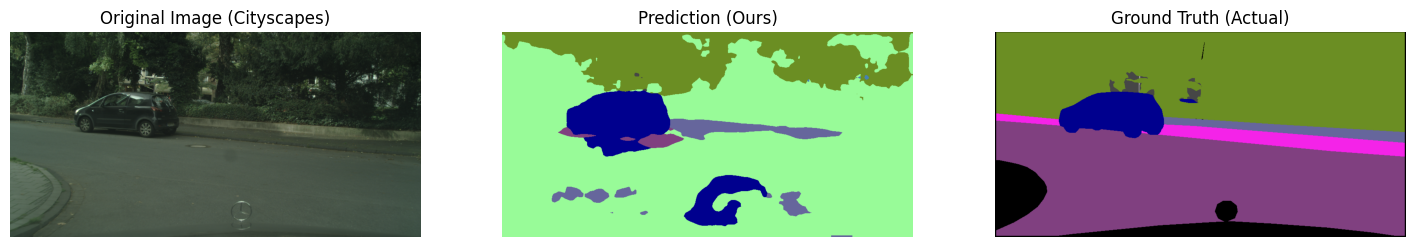

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image
import os
import random
from models.bisenet.build_bisenet import BiSeNet
import torchvision.transforms as transforms

# --- 1. CONFIGURATION ---
CITYSCAPES_PATH = '/content/dataset/project_data/cityscapes'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_CLASSES = 19

# Cityscapes Color Palette
palette = [
    [128, 64, 128],  # 0: Road
    [244, 35, 232],  # 1: Sidewalk
    [70, 70, 70],    # 2: Building
    [102, 102, 156], # 3: Wall
    [190, 153, 153], # 4: Fence
    [153, 153, 153], # 5: Pole
    [250, 170, 30],  # 6: Traffic Light
    [220, 220, 0],   # 7: Traffic Sign
    [107, 142, 35],  # 8: Vegetation
    [152, 251, 152], # 9: Terrain
    [70, 130, 180],  # 10: Sky
    [220, 20, 60],   # 11: Person
    [255, 0, 0],     # 12: Rider
    [0, 0, 142],     # 13: Car
    [0, 0, 70],      # 14: Truck
    [0, 60, 100],    # 15: Bus
    [0, 80, 100],    # 16: Train
    [0, 0, 230],     # 17: Motorcycle
    [119, 11, 32]    # 18: Bicycle
]

# --- 2. LOAD MODEL ---
print("⏳ Loading Model...")
model = BiSeNet(num_classes=NUM_CLASSES, context_path='resnet18')
model.to(DEVICE)
checkpoint = torch.load('/content/drive/MyDrive/bisenet_gta5_checkpoint.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# --- 3. PICK RANDOM IMAGE (SAFE METHOD) ---
val_img_dir = os.path.join(CITYSCAPES_PATH, 'leftImg8bit', 'val')
cities = sorted(os.listdir(val_img_dir))
random_city = random.choice(cities)
city_path = os.path.join(val_img_dir, random_city)

# Filter for image files only
files = [f for f in os.listdir(city_path) if f.endswith('_leftImg8bit.png')]
random_file = random.choice(files)

# Construct paths safely
img_path = os.path.join(city_path, random_file)
mask_name = random_file.replace('_leftImg8bit.png', '_gtFine_labelTrainIds.png')
mask_path = os.path.join(CITYSCAPES_PATH, 'gtFine', 'val', random_city, mask_name)

print(f"📸 Visualizing: {random_file}")

# --- 4. PREDICT ---
image = Image.open(img_path).convert('RGB')
eval_size = (1024, 512)

# Preprocess
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = transform(image.resize(eval_size, Image.BILINEAR)).unsqueeze(0).to(DEVICE)

with torch.no_grad():
    output = model(input_tensor)
    if isinstance(output, tuple): output = output[0]
    pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

# --- 5. LOAD GROUND TRUTH ---
if os.path.exists(mask_path):
    gt_mask = Image.open(mask_path).resize(eval_size, Image.NEAREST)
    gt_mask = np.array(gt_mask)
else:
    print(f"⚠️ Warning: Could not find mask at {mask_path}")
    gt_mask = np.zeros(pred_mask.shape, dtype=np.uint8) # Blank mask if missing

# --- 6. COLORIZE ---
def colorize(mask):
    h, w = mask.shape
    img = np.zeros((h, w, 3), dtype=np.uint8)
    for id_val, color in enumerate(palette):
        # Only map valid classes (0-18)
        mask_bool = (mask == id_val)
        img[mask_bool] = color
    return img

pred_color = colorize(pred_mask)
gt_color = colorize(gt_mask)

# --- 7. PLOT ---
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title("Original Image (Cityscapes)")
plt.imshow(image.resize(eval_size))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title(f"Prediction (Ours)")
plt.imshow(pred_color)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Ground Truth (Actual)")
plt.imshow(gt_color)
plt.axis('off')

plt.show()